# 회귀 분석

## 이진 고객 이탈

고객의 웹사이트 광고를 제공하는 마케팅 대행사에서 당사의 고객이탈율이 꽤 높다는 사실을 알게됐습니다.<br>
그 회사에서는 즉시 고객 관리자들을 할당했지만, 어떤 고객이 이탈 할 것인지 예측하는 기계학습 모델을 만들어서 가장 이탈확률이 높은 고객에게 우선적으로 고객 관리자를 배치할 수 있기를 원합니다.<br>
고객이 잠재적 이탈 고객인지 여부를 분류하는 분류모델을 만드세요.

데이터는 customer_churn.csv로 저장돼있습니다. 아래는 각 컬럼의 정의입니다.
- Name : 회사의 최근 담당자의 이름
- Age : 고객의 나이
- Total_Purchase : 구매한 총 광고
- Account_Manager : 바이너리 0 = 고객 관리자 없음, 1 = 고객 관리자 할당됨
- Years : 거래 유지 연도수
- Num_sites : 서비스를 이용 중인 웹사이트 수
- Onboard_date : 마지막 연락처가 등록된 날짜
- Location : 고객 사무실 주소
- Company : 고객 회사의 이름

모델 생성 후에는 고객이 제공하는 new_customers.csv 파일에 저장된 새로운 데이터에 대한 예측값을 제시하세요. <br>
고객은 이 데이터를 통해 관리가 필요한 고객들을 알고 싶어 합니다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import seaborn as sns
import math
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier)

### 데이터 불러오기

In [2]:
df = pd.read_csv("./data/customer_churn.csv")

### 데이터 확인

In [3]:
df.head()

,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Onboard_date,Location,Company,Churn
0,Cameron Williams,42.0,11066.80,0,7.22,8.0,2013-08-30 07:00:40,"10265 Elizabeth Mission Barkerburgh, AK 89518",Harvey LLC,1
1,Kevin Mueller,41.0,11916.22,0,6.50,11.0,2013-08-13 00:38:46,"6157 Frank Gardens Suite 019 Carloshaven, RI 1...",Wilson PLC,1
2,Eric Lozano,38.0,12884.75,0,6.67,12.0,2016-06-29 06:20:07,"1331 Keith Court Alyssahaven, DE 90114","Miller, Johnson and Wallace",1
3,Phillip White,42.0,8010.76,0,6.71,10.0,2014-04-22 12:43:12,"13120 Daniel Mount Angelabury, WY 30645-4695",Smith Inc,1
4,Cynthia Norton,37.0,9191.58,0,5.56,9.0,2016-01-19 15:31:15,"765 Tricia Row Karenshire, MH 71730",Love-Jones,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Names            900 non-null    object 
 1   Age              900 non-null    float64
 2   Total_Purchase   900 non-null    float64
 3   Account_Manager  900 non-null    int64  
 4   Years            900 non-null    float64
 5   Num_Sites        900 non-null    float64
 6   Onboard_date     900 non-null    object 
 7   Location         900 non-null    object 
 8   Company          900 non-null    object 
 9   Churn            900 non-null    int64  
dtypes: float64(4), int64(2), object(4)
memory usage: 70.4+ KB


In [5]:
df["Names"].value_counts()

Names
Jennifer Wood        2
Cameron Williams     1
Stacy Marshall       1
Christopher Clark    1
Rose White           1
                    ..
Ashley Smith         1
Sandra Mcintyre      1
Robert Joseph        1
George Chavez        1
Joseph Williams      1
Name: count, Length: 899, dtype: int64

- 이름 잘가라...

In [6]:
df["Onboard_date"].value_counts()

Onboard_date
2013-08-30 07:00:40    1
2015-10-06 18:31:32    1
2012-04-22 17:32:15    1
2006-03-29 18:27:06    1
2011-08-29 06:35:54    1
                      ..
2011-10-07 15:43:59    1
2007-09-19 06:55:51    1
2010-08-02 09:34:35    1
2015-04-03 16:15:00    1
2010-09-25 12:16:08    1
Name: count, Length: 900, dtype: int64

In [7]:
df["Location"].value_counts()

Location
10265 Elizabeth Mission Barkerburgh, AK 89518            1
4331 Quinn Fords Suite 546 Traceyfort, CO 47194-7606     1
69666 Christian Forges Lake Noah, IL 14397               1
715 Ellis Squares New Kathleenland, NY 05913             1
3004 Nash Freeway North Craigville, CT 24488             1
                                                        ..
3785 Duran Lodge Port Nicholashaven, MH 08892-1815       1
663 White Tunnel Suite 995 Port Joseph, PR 93959-2444    1
10676 Ferguson Ranch Suite 380 Lake Parker, OH 23498     1
95222 Lisa Turnpike South Laurenburgh, NC 33273-8443     1
27252 Olivia Burgs Rivasmouth, MN 80121-6348             1
Name: count, Length: 900, dtype: int64

- 집 주소는 관계 없어보여 삭제할 예정(너도 잘가라)

In [8]:
df["Company"].value_counts()

Company
Anderson Group                     4
Williams PLC                       3
Wilson PLC                         3
Smith Group                        2
Williams LLC                       2
                                  ..
Cowan Inc                          1
Cortez Inc                         1
Rodriguez, Moore and Cunningham    1
Bennett Ltd                        1
Robles-Abbott                      1
Name: count, Length: 873, dtype: int64

- 회사명 역시 관계 없어보여 삭제할 예정(취업만 시켜주시면 써드립니다^^)

In [9]:
rdf = df.drop(["Names", "Location", "Company"], axis = 1)

In [10]:
ndf = rdf.drop("Onboard_date", axis = 1)

In [11]:
ndf.describe()

,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Churn
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,41.816667,10062.824033,0.481111,5.273156,8.587778,0.166667
std,6.127560,2408.644532,0.499921,1.274449,1.764836,0.372885
min,22.000000,100.000000,0.000000,1.000000,3.000000,0.000000
25%,38.000000,8497.122500,0.000000,4.450000,7.000000,0.000000
50%,42.000000,10045.870000,0.000000,5.215000,8.000000,0.000000
75%,46.000000,11760.105000,1.000000,6.110000,10.000000,0.000000
max,65.000000,18026.010000,1.000000,9.150000,14.000000,1.000000


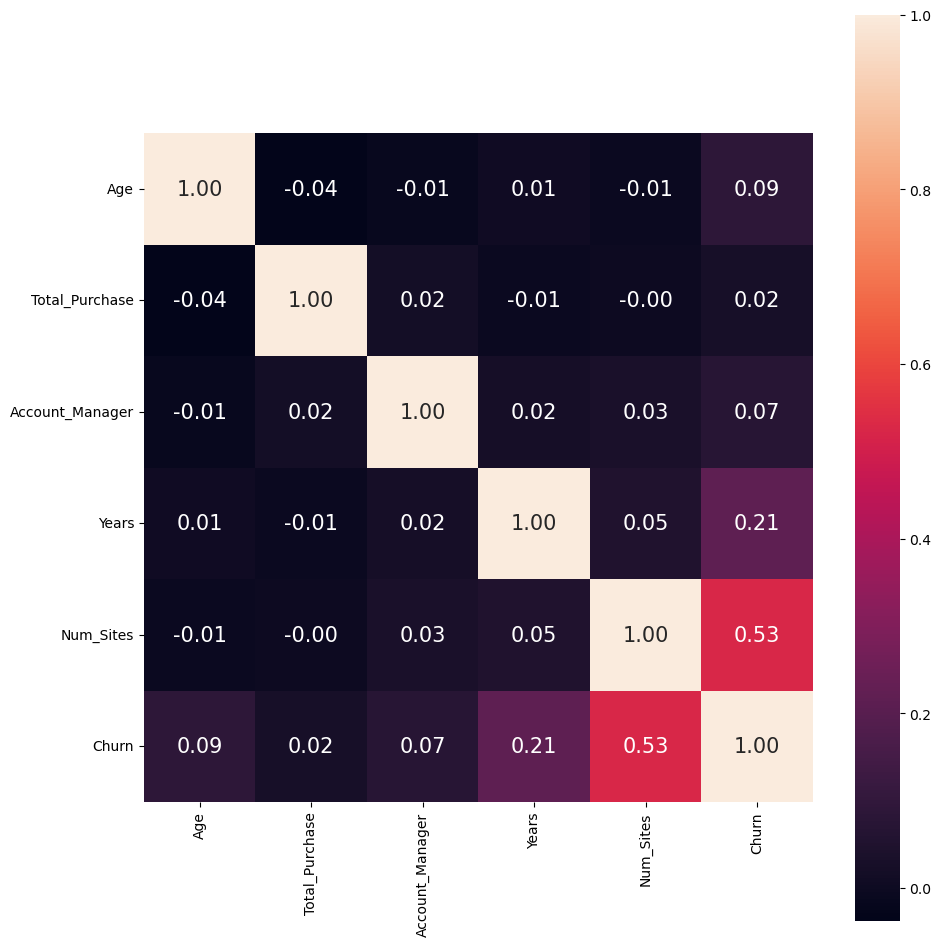

In [12]:
plt.figure(figsize = (10,10))
corr = rdf.drop("Onboard_date", axis = 1).corr()
hm = sns.heatmap(corr.values, cbar = True, annot = True, square = True, fmt = ".2f", annot_kws = {"size" : 15},
                yticklabels = rdf.drop("Onboard_date", axis = 1).columns, xticklabels = rdf.drop("Onboard_date", axis = 1).columns)

plt.tight_layout()
plt.show()

- Churn은 Num_Sites와 Years를 제외하고는 큰 영향을 미치지 않을 것으로 예상됨

In [13]:
new_x = sm.add_constant(ndf.drop(["Churn"], axis = 1))
model = sm.Logit(df["Churn"], new_x)
model = model.fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.261624
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Churn   No. Observations:                  900
Model:                          Logit   Df Residuals:                      894
Method:                           MLE   Df Model:                            5
Date:                Mon, 01 Apr 2024   Pseudo R-squ.:                  0.4193
Time:                        14:51:57   Log-Likelihood:                -235.46
converged:                       True   LL-Null:                       -405.51
Covariance Type:            nonrobust   LLR p-value:                 2.383e-71
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -19.3426      1.707    -11.328      0.000     -22.689     -15.996
Age                 0.0598      0.020      2.936      0.003       0.020       0.100
Total_Purchase   3.731e-05   5.02e-05      0.743      0.457   -6.11e-05       0.000
Account_Manager     0.4810      0.238      2.018      0.044       0.014       0.948
Years               0.5660      0.094      5.996      0.000       0.381       0.751
Num_Sites           1.2116      0.099     12.179      0.000       1.017       1.407
===================================================================================
"""

In [14]:
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(new_x.values, i) for i in range(new_x.shape[1])]
vif["feature"] = new_x.columns
vif.round(1)

,VIF_Factor,feature
0,107.2,const
1,1.0,Age
2,1.0,Total_Purchase
3,1.0,Account_Manager
4,1.0,Years
5,1.0,Num_Sites


In [15]:
new_x = sm.add_constant(ndf.drop(["Churn", "Account_Manager", "Total_Purchase"], axis = 1))
model = sm.Logit(df["Churn"], new_x)
model = model.fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.264201
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Churn   No. Observations:                  900
Model:                          Logit   Df Residuals:                      896
Method:                           MLE   Df Model:                            3
Date:                Mon, 01 Apr 2024   Pseudo R-squ.:                  0.4136
Time:                        14:51:57   Log-Likelihood:                -237.78
converged:                       True   LL-Null:                       -405.51
Covariance Type:            nonrobust   LLR p-value:                 2.111e-72
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -18.5496      1.565    -11.851      0.000     -21.617     -15.482
Age            0.0575      0.020      2.849      0.004       0.018       0.097
Years          0.5733      0.094      6.096      0.000       0.389       0.758
Num_Sites      1.2000      0.098     12.243      0.000       1.008       1.392
==============================================================================
"""

In [16]:
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(new_x.values, i) for i in range(new_x.shape[1])]
vif["feature"] = new_x.columns
vif.round(1)

,VIF_Factor,feature
0,86.6,const
1,1.0,Age
2,1.0,Years
3,1.0,Num_Sites


In [17]:
# 시각화용 데이터 추가
age_10 = []
for i in range(len(df)):
    i = math.floor(df["Age"][i]/10)*10
    age_10.append(i)

ndf["Age_10"] = age_10

year = []
for i in range(len(df)):
    i = int(df["Onboard_date"][i][:4])
    year.append(i)

ndf["Onboard_date_year"] = year

Purchase = []
for i in range(len(df)):
    i = math.floor(df["Total_Purchase"][i]/1000)*1000
    Purchase.append(i)
    
ndf["Purchase"] = Purchase

years = []
for i in range(len(df)):
    i = int(math.floor(df["Years"][i]))
    years.append(i)
    
ndf["years"] = years

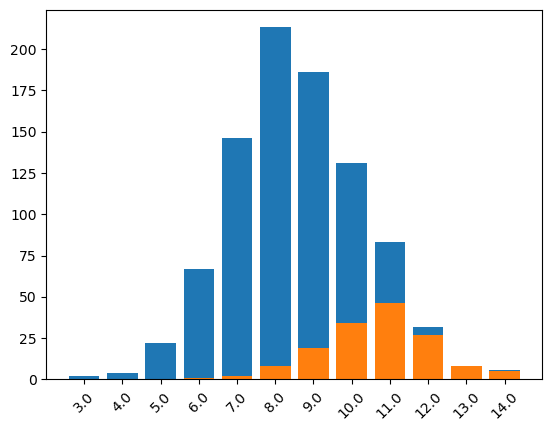

In [18]:
x = pd.concat([ndf[["Num_Sites", "Churn"]].groupby("Num_Sites").sum(),ndf["Num_Sites"].value_counts()], axis = 1)
x = x.reset_index()
    
plt.bar(np.arange(len(x)), x["count"])
plt.bar(np.arange(len(x)), x["Churn"])
plt.xticks(np.arange(len(x)), x["Num_Sites"], size = 10, rotation = 45)

plt.show()

- 11개 이상의 사이트 이용시 탈주 확률이 높아보임

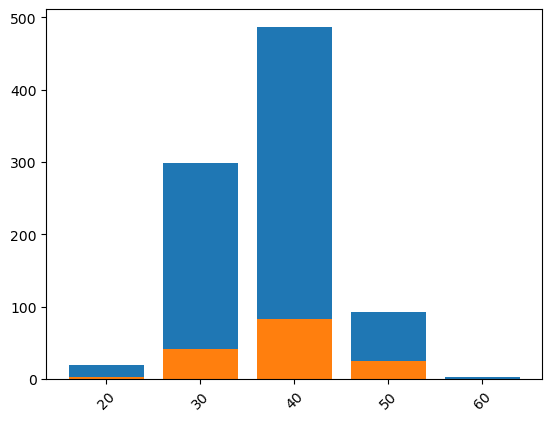

In [19]:
x = pd.concat([ndf[["Age_10", "Churn"]].groupby("Age_10").sum(),ndf["Age_10"].value_counts()], axis = 1)
x = x.reset_index()
    
plt.bar(np.arange(len(x)), x["count"])
plt.bar(np.arange(len(x)), x["Churn"])
plt.xticks(np.arange(len(x)), x["Age_10"], size = 10, rotation = 45)

plt.show()

- 40대가 수 적으로 많아 보임
- 비율은....umm....

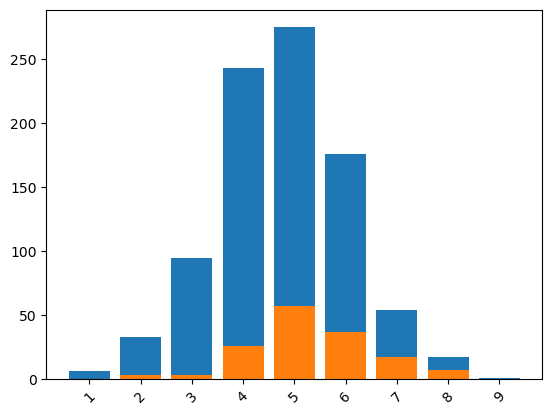

In [20]:
x = pd.concat([ndf[["years", "Churn"]].groupby("years").sum(),ndf["years"].value_counts()], axis = 1)
x = x.reset_index()
    
plt.bar(np.arange(len(x)), x["count"])
plt.bar(np.arange(len(x)), x["Churn"])
plt.xticks(np.arange(len(x)), x["years"], size = 10, rotation = 45)

plt.show()

- 수는 5년차가 많아 보이나 비율은 6, 7년차가 높을 것으로 예상

### 머신러닝용 데이터 전처리

우리는 수치형 데이터만 이용할 예정입니다. Account_Manager는 다루기 어렵지 않기 때문에 모델학습에 포함할 수도 있겠지만 무작위로 할당된 것이기 때문에 큰 의미가 없을 수 있습니다.

- P-value가 낮게 설정된 Age와 Years, Num_sites로 0, 1 로 이진분류하기 위해 로지스틱 회귀 사용

In [21]:
x = rdf.drop(["Onboard_date", "Churn", "Account_Manager", "Total_Purchase"], axis = 1)
y = rdf["Churn"]

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, stratify = y, random_state = 0)

In [23]:
ss = StandardScaler()
scaled_train = ss.fit_transform(x_train)
scaled_test = ss.transform(x_test)
scaled_x = ss.transform(x)

In [24]:
logi = LogisticRegression()
logi.fit(scaled_x, y)

LogisticRegression()

In [25]:
scores = cross_validate(logi, scaled_x, y, scoring = "roc_auc")
print(scores["test_score"])
print(np.mean(scores["test_score"]))

[0.87044444 0.92       0.92444444 0.86644444 0.93155556]
0.9025777777777778


In [26]:
logi.fit(scaled_train, y_train)

LogisticRegression()

In [27]:
scores = cross_validate(logi, x_train, y_train, scoring = "roc_auc")
print(scores["test_score"])
print(np.mean(scores["test_score"]))
print(logi.score(scaled_train, y_train))
print(logi.score(scaled_test, y_test))

[0.95464853 0.85351474 0.93650794 0.86712018 0.95827664]
0.9140136054421768
0.9031746031746032
0.8814814814814815


In [28]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, stratify = y, random_state = 14)

In [29]:
scaled_train = ss.fit_transform(x_train)
scaled_test = ss.transform(x_test)

In [30]:
logi.fit(scaled_train, y_train)

LogisticRegression()

In [31]:
scores = cross_validate(logi, x_train, y_train, scoring = "roc_auc")
print(scores["test_score"])
print(np.mean(scores["test_score"]))
print(logi.score(scaled_train, y_train))
print(logi.score(scaled_test, y_test))

[0.9723356  0.87165533 0.93786848 0.94195011 0.88979592]
0.9227210884353741
0.9
0.8814814814814815


In [32]:
df_test = pd.read_csv("./data/new_customers.csv", index_col = False)

In [33]:
df_test

,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Onboard_date,Location,Company
0,Andrew Mccall,37.0,9935.53,1,7.71,8.0,2011-08-29 18:37:54,"38612 Johnny Stravenue Nataliebury, WI 15717-8316",King Ltd
1,Michele Wright,23.0,7526.94,1,9.28,15.0,2013-07-22 18:19:54,"21083 Nicole Junction Suite 332, Youngport, ME...",Cannon-Benson
2,Jeremy Chang,65.0,100.00,1,1.00,15.0,2006-12-11 07:48:13,"085 Austin Views Lake Julialand, WY 63726-4298",Barron-Robertson
3,Megan Ferguson,32.0,6487.50,0,9.40,14.0,2016-10-28 05:32:13,"922 Wright Branch North Cynthialand, NC 64721",Sexton-Golden
4,Taylor Young,32.0,13147.71,1,10.00,8.0,2012-03-20 00:36:46,Unit 0789 Box 0734 DPO AP 39702,Wood LLC
5,Jessica Drake,22.0,8445.26,1,3.46,14.0,2011-02-04 19:29:27,1148 Tina Stravenue Apt. 978 South Carlos TX 2...,Parks-Robbins


In [34]:
df_test = df_test[["Age", "Years", "Num_Sites"]]

In [35]:
scaled_df_test = ss.transform(df_test)

In [36]:
logi.predict(scaled_df_test)

array([0, 1, 1, 1, 0, 1], dtype=int64)

- Age와 Years, Num_sites 만 가지고 다른 나무들 사용(벚꽃나무 이쁘게 폈으니 벚꽃 구경 가세요들 >.< )

In [37]:
rf = RandomForestClassifier(n_jobs = -1, random_state = 0)
et = ExtraTreesClassifier(n_jobs = -1, random_state = 0)
gb = GradientBoostingClassifier(random_state = 0)

In [38]:
scores = cross_validate(rf, x_train, y_train, return_train_score = True, n_jobs = -1, scoring = "roc_auc")
print(scores["test_score"])
print(np.mean(scores["test_score"]))

[0.90566893 0.85759637 0.90544218 0.91360544 0.88185941]
0.8928344671201813


In [39]:
scores = cross_validate(et, x_train, y_train, return_train_score = True, n_jobs = -1, scoring = "roc_auc")
print(scores["test_score"])
print(np.mean(scores["test_score"]))

[0.9015873  0.84376417 0.89297052 0.8952381  0.81473923]
0.8696598639455783


In [40]:
scores = cross_validate(gb, x_train, y_train, return_train_score = True, n_jobs = -1, scoring = "roc_auc")
print(scores["test_score"])
print(np.mean(scores["test_score"]))

[0.93015873 0.88095238 0.89977324 0.91201814 0.91020408]
0.9066213151927437


- Onboard_date를 연도데이터로 바꾼 후 모든 데이터 사용하여 돌려보기

In [41]:
x = ndf.drop(["Churn", "years", "Purchase", "Age_10"], axis = 1)
y = rdf["Churn"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, stratify = y, random_state = 14)

In [42]:
scores = cross_validate(rf, x_train, y_train, return_train_score = True, n_jobs = -1, scoring = "roc_auc")
print(scores["test_score"])
print(np.mean(scores["test_score"]))

[0.94399093 0.86870748 0.93650794 0.92290249 0.90657596]
0.9157369614512472


In [43]:
scores = cross_validate(et, x_train, y_train, return_train_score = True, n_jobs = -1, scoring = "roc_auc")
print(scores["test_score"])
print(np.mean(scores["test_score"]))

[0.90340136 0.89092971 0.95283447 0.91179138 0.8845805 ]
0.9087074829931971


In [44]:
scores = cross_validate(gb, x_train, y_train, return_train_score = True, n_jobs = -1, scoring = "roc_auc")
print(scores["test_score"])
print(np.mean(scores["test_score"]))

[0.93514739 0.91292517 0.92244898 0.93061224 0.88208617]
0.9166439909297053


- 모든 데이터 학습해보기

In [45]:
scores = cross_validate(rf, x, y, return_train_score = True, n_jobs = -1, scoring = "roc_auc")
print(scores["test_score"])
print(np.mean(scores["test_score"]))

[0.831      0.86888889 0.88677778 0.90588889 0.92188889]
0.8828888888888888


In [46]:
scores = cross_validate(et, x, y, return_train_score = True, n_jobs = -1, scoring = "roc_auc")
print(scores["test_score"])
print(np.mean(scores["test_score"]))

[0.84533333 0.87911111 0.89088889 0.88066667 0.91811111]
0.8828222222222222


In [47]:
scores = cross_validate(gb, x, y, return_train_score = True, n_jobs = -1, scoring = "roc_auc")
print(scores["test_score"])
print(np.mean(scores["test_score"]))

[0.82644444 0.88933333 0.88422222 0.90822222 0.92711111]
0.8870666666666667


- 이 중 뭐 하나는 맞겠지... 신청곡으로 빅뱅의 "에라 모르겠다" 틀어주세요